## Problem Statement
- The clustering of the Indic languages based on linguistic features.

### Dataset Overview
- The dataset contains 8 different languages, consisting of 4 Indo-Aryan and 4 Dravidian languages.
- Each individual language contains 1500 samples for training.
- `Hindi    `→ Indo-Aryan
- `Gujarati `→ Indo-Aryan
- `Punjabi  `→ Indo-Aryan
- `Marathi  `→ Indo-Aryan
- `Tamil    `→ Dravidian
- `Telugu   `→ Dravidian
- `Kannada  `→ Dravidian
- `Malayalam`→ Dravidian

### Importing Necessary Libraries

In [81]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer , AutoModel
from sklearn.cluster import KMeans , AgglomerativeClustering , DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

### Load and Preprocess the Dataset

In [2]:
data = pd.read_csv("indic-language.csv")

In [3]:
data.head()

Headline   Language
0  श्रद्धा कपूर को महादेव बेटिंग ऐप घोटाला में ईड...      Hindi
1  ഇന്ത്യ തോറ്റതിന് കാരണം ഇതാണ് ; ധവാന്റെ വെളിപ്പ...  Malayalam
2  डीपफेक से पीड़ित सभी लोग अपने नज़दीकी पुलिस स्टे...      Hindi
3  ತಮಿಳಲ್ಲಿ ಮಾತನಾಡಿ ಕಾಲಿವುಡ್​ ಪ್ರೇಕ್ಷಕರ ಮನಗೆದ್ದ ರ...    Kannada
4  हाथरस हादसाः नारायण साकार के चरणों की धूल को ल...      Hindi

In [4]:
data['Language'].value_counts()

Language
Punjabi      10552
Hindi         9428
Marathi       4637
Gujarati      2652
Telugu        2494
Malayalam     2396
Tamil         2236
Kannada       1856
Name: count, dtype: int64

In [15]:
data = data.groupby('Language').head(1500).reset_index(drop = True)

In [16]:
data = data[data['Headline'].str.strip().astype(bool)]

In [17]:
data['Language'].value_counts()

Language
Hindi        1500
Malayalam    1500
Kannada      1500
Telugu       1500
Marathi      1500
Gujarati     1500
Punjabi      1500
Tamil        1500
Name: count, dtype: int64

In [18]:
data.head()

Headline   Language
0  श्रद्धा कपूर को महादेव बेटिंग ऐप घोटाला में ईड...      Hindi
1  ഇന്ത്യ തോറ്റതിന് കാരണം ഇതാണ് ; ധവാന്റെ വെളിപ്പ...  Malayalam
2  डीपफेक से पीड़ित सभी लोग अपने नज़दीकी पुलिस स्टे...      Hindi
3  ತಮಿಳಲ್ಲಿ ಮಾತನಾಡಿ ಕಾಲಿವುಡ್​ ಪ್ರೇಕ್ಷಕರ ಮನಗೆದ್ದ ರ...    Kannada
4  हाथरस हादसाः नारायण साकार के चरणों की धूल को ल...      Hindi

## Load AutoTokenizer and Model
- The primary role of the tokenizer is to perform the necessary preprocessing steps to convert raw human-readable     text into a structured, numerical format that the specific transformer model was trained to understand.

### IndicBert Model
- For this project, the IndicBERT model was chosen because it's specifically trained on Indic languages for embedding.

In [19]:
model_name = './indic-bert'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

The tokenizer you are loading from './indic-bert' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


### Performing Embedding

- The tokenizer prepares the input for the model and the model provides the output.
- We chose **Mean Pooling** instead of CLS because it performs better in tasks like semantic meaning and it effectively captures the overall meaning.

In [20]:
def transform_text(text : str) -> np.ndarray:

    inputs = tokenizer(text , return_tensors='pt' , padding = True , truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state.mean(dim = 1).numpy()

In [21]:
transformed_text = data['Headline'].apply(transform_text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [22]:
input_array = np.stack(transformed_text.to_list()).squeeze()

In [33]:
data['embedded_text'] = input_array

In [34]:
data.to_csv('embedded-indic-language.csv')

## Model Training

### Clustering Using the KMeans Model
- We chose the two clusters because we have two families of languages: Indo-Aryan and Dravidian.

In [37]:
km = KMeans(n_clusters=2)
km.fit(input_array)

KMeans(n_clusters=2)

### Clustering Using the Agglomerative Model

In [39]:
ac = AgglomerativeClustering()
ac.fit(input_array)

AgglomerativeClustering()

### Clustering Using the DBSCAN

- Choosing the right minPts and epsilon value using a plot.

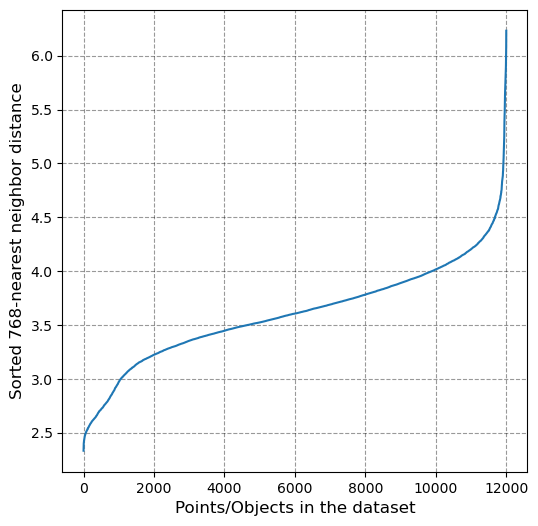

In [40]:
minPts = 769
k = minPts - 1

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(6,6))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


get_kdist_plot(X=input_array, k=k)

In [41]:
dbscan = DBSCAN(min_samples= minPts , eps=4.25)
data['pre_dbscan'] = dbscan.fit_predict(input_array)

### Calculate the Silhouette Score for every Model

In [42]:
data['pre_Kmeans'] = km.predict(input_array)

silhouette_val_kmeans = silhouette_score(input_array , data['pre_Kmeans'])
print(silhouette_val_kmeans)

0.1079464


In [43]:
data['pre_Agglomerative'] = ac.labels_

silhouette_val_agg = silhouette_score(input_array , data['pre_Agglomerative'])
print(silhouette_val_agg)

0.10458234


In [44]:
silhouette_val_dbscan =  silhouette_score(input_array , data['pre_dbscan'])
print(silhouette_val_dbscan)

0.2751495


### Interpretation of Silhouette Score
- `KMeans        `→ 0.1079
- `Agglomerative `→ 0.1045
- `DBSCAN        `→ 0.2407
  
- In all model DBSCAN give the better results in scores.

### Applying PCA for Visualization in 2-D

In [45]:
pc = PCA(n_components=2)
pca_2d_axis = pc.fit_transform(input_array)

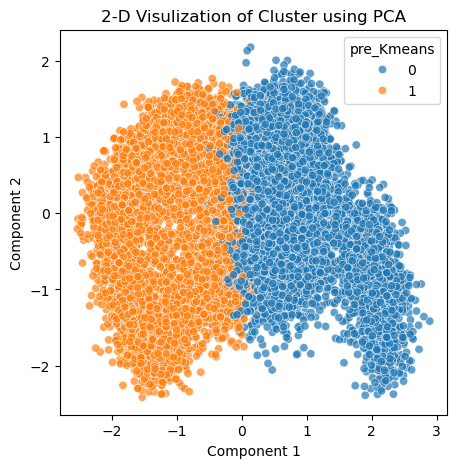

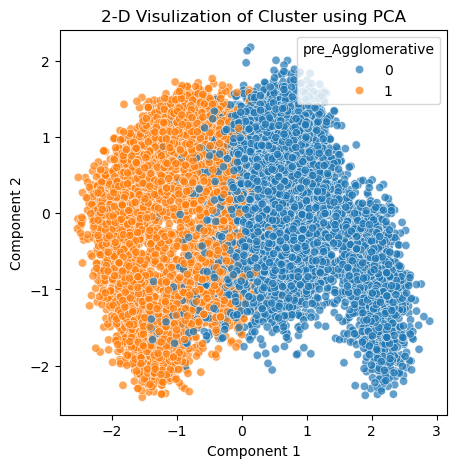

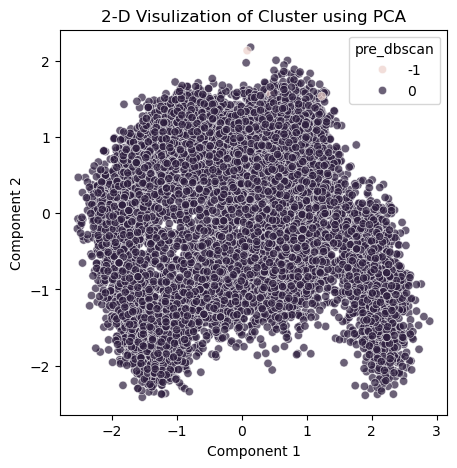

In [46]:
for prediction in ['pre_Kmeans' , 'pre_Agglomerative' , 'pre_dbscan']:
    plt.figure(figsize = (5,5))
    sns.scatterplot(x =  pca_2d_axis[:,0] , y = pca_2d_axis[:,1]  , hue = data[prediction] , alpha = 0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("2-D Visulization of Cluster using PCA")
    plt.show()

### Applying TSNE for Visualization in 2-D

In [48]:
tsn = TSNE(n_components=2)
tsne_2d_axis = tsn.fit_transform(input_array)

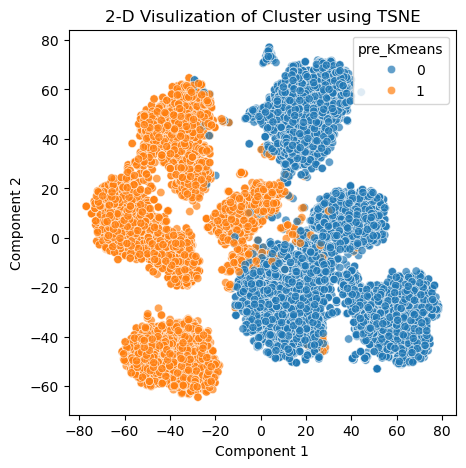

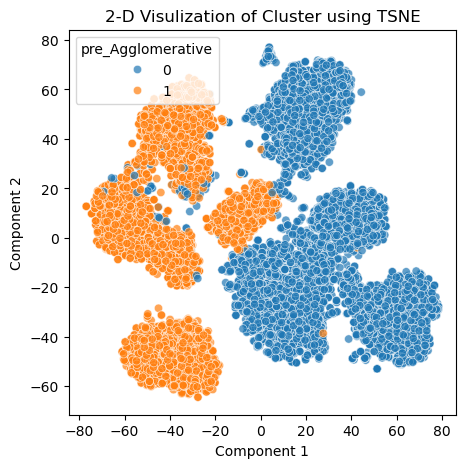

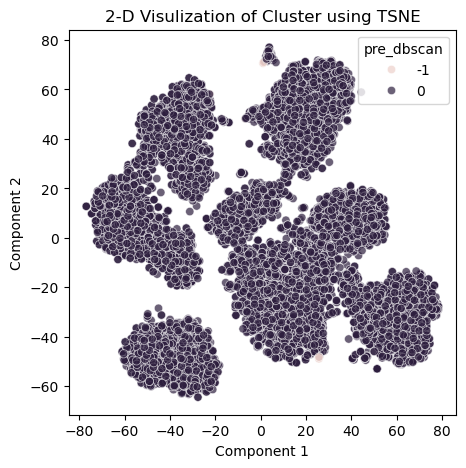

In [49]:
for prediction in ['pre_Kmeans' , 'pre_Agglomerative' , 'pre_dbscan']:
    plt.figure(figsize=(5,5))
    sns.scatterplot(x = tsne_2d_axis[:,0] , y = tsne_2d_axis[:,-1] , hue = data[prediction] , alpha = 0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("2-D Visulization of Cluster using TSNE")
    plt.show()

### Applying PCA for Visualization in 3-D

In [ ]:
pca1 = PCA(n_components=3)
pca_3d_axis = pca1.fit_transform(input_array)

In [75]:
for prediction in ['pre_Kmeans' , 'pre_Agglomerative' , 'pre_dbscan']:
    
    fig = px.scatter_3d(
        x=pca_3d_axis[:,0], 
        y=pca_3d_axis[:,1], 
        z=pca_3d_axis[:,2],
        color=data[prediction],
        color_continuous_scale='Hot',
        title=f'3-D Visulization using PCA {prediction}',
        labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'}
    )

    # --- 3. Apply Minimalist Layout Update ---
    fig.update_layout(
        height = 500,
        width = 500,
        showlegend = True,

        
        # Hide the color bar legend (if present)
        coloraxis_showscale=False, 
        
        # Target the 'scene' object for 3D settings
        scene=dict(
            # Hide the axes labels and titles

            # Make the background and gridlines transparent/white
            xaxis_backgroundcolor="rgba(0,0,0,0)",
            yaxis_backgroundcolor="rgba(0,0,0,0)",
            zaxis_backgroundcolor="rgba(0,0,0,0)",
            
            # Hide the cube boundaries
            # Note: Setting the bounding box color to match the background helps
            # aspectmode='data' or 'cube' can also help frame the view
            
            # Optional: Set the camera view to a standard angle
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.25, y=1.25, z=1.25)
            )
        ),
        
        # Set the overall plot and paper background to transparent/white
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        
        # Set height/width as needed
    )

    fig.show()

### Applying TSNE for Visualization in 3-D

In [67]:
tsne1 = TSNE(n_components=3)
tsne_3d_axis = tsne1.fit_transform(input_array)

In [76]:
for prediction in ['pre_Kmeans' , 'pre_Agglomerative' , 'pre_dbscan']:
    
    fig = px.scatter_3d(
        x=tsne_3d_axis[:,0], 
        y=tsne_3d_axis[:,1], 
        z=tsne_3d_axis[:,2],
        color=data[prediction],
        color_continuous_scale='Hot',
        title=f'3-D Visulization using PCA {prediction}',
        labels={'x': 'Component 1', 'y': 'Component 2', 'z': 'Component 3'}
    )

    # --- 3. Apply Minimalist Layout Update ---
    fig.update_layout(
        height = 500,
        width = 500,
        showlegend = True,

        
        # Hide the color bar legend (if present)
        coloraxis_showscale=False, 
        
        # Target the 'scene' object for 3D settings
        scene=dict(
            # Hide the axes labels and titles

            # Make the background and gridlines transparent/white
            xaxis_backgroundcolor="rgba(0,0,0,0)",
            yaxis_backgroundcolor="rgba(0,0,0,0)",
            zaxis_backgroundcolor="rgba(0,0,0,0)",
            
            # Hide the cube boundaries
            # Note: Setting the bounding box color to match the background helps
            # aspectmode='data' or 'cube' can also help frame the view
            
            # Optional: Set the camera view to a standard angle
            camera=dict(
                up=dict(x=0, y=0, z=1),
                center=dict(x=0, y=0, z=0),
                eye=dict(x=1.25, y=1.25, z=1.25)
            )
        ),
        
        # Set the overall plot and paper background to transparent/white
        paper_bgcolor="rgba(0,0,0,0)",
        plot_bgcolor="rgba(0,0,0,0)",
        
        # Set height/width as needed
    )

    fig.show()

### Interpretation and Findings of Visulization

Although DBSCAN achieved the highest silhouette score (0.2407), its cluster visualization
was noisy and did not reflect real linguistic grouping. The high score occurred because
DBSCAN marked many points as noise, artificially boosting the metric.

KMeans, despite a lower silhouette score (0.1079), produced well-separated and meaningful
clusters aligned with Indo-Aryan and Dravidian linguistic families, making it the most
appropriate model for this task.


### Calculate the Centroids of all languages

In [77]:
language_centroids = {}

for lang in data['Language'].unique():

    lang_array = input_array[data['Language'] == lang]

    language_centroids[lang] = np.mean(lang_array , axis = 0)


In [78]:
centroid_matrix = np.vstack(list(language_centroids.values()))
languages = list(language_centroids.keys())

### Calculate the Cosine Similarity between languages

- Higher value of cosine similarity indicates higer correlated with each other or similary semantic
  relation.

In [79]:
similarity_matrix = cosine_similarity(centroid_matrix)
print(similarity_matrix)

[[0.99999994 0.8633031  0.88874936 0.8720779  0.93108344 0.9154604
  0.93389976 0.8117675 ]
 [0.8633031  1.0000002  0.90173745 0.8797282  0.90183026 0.8516204
  0.83649766 0.85235584]
 [0.88874936 0.90173745 0.9999999  0.93503076 0.9417466  0.913265
  0.8667574  0.8851453 ]
 [0.8720779  0.8797282  0.93503076 1.0000002  0.92288613 0.874475
  0.8662038  0.8714708 ]
 [0.93108344 0.90183026 0.9417466  0.92288613 1.0000002  0.92564046
  0.90473884 0.8700714 ]
 [0.9154604  0.8516204  0.913265   0.874475   0.92564046 1.0000001
  0.8918127  0.8234234 ]
 [0.93389976 0.83649766 0.8667574  0.8662038  0.90473884 0.8918127
  0.9999998  0.7926185 ]
 [0.8117675  0.85235584 0.8851453  0.8714708  0.8700714  0.8234234
  0.7926185  0.9999999 ]]


### Plot the HeatMap

- Plotting the HeatMap for the visualization of cosine similarity between languages.

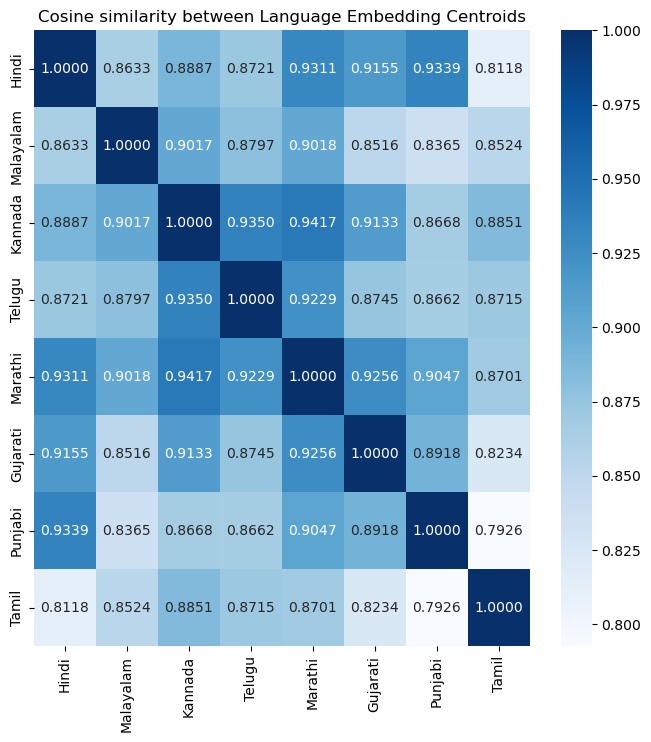

In [80]:
plt.figure(figsize=(8,8))
sns.heatmap(similarity_matrix,
            annot = True,
            fmt = '.4f', 
            xticklabels=languages,
            yticklabels=languages,
            cmap = 'Blues')
plt.title("Cosine similarity between Language Embedding Centroids")
plt.show()

### Saving the Objects

- Saving the languages centroids and KMeans model object as a pickle file.
- This pickle file is later used for prediction and to calculate the similarity for all languages.

In [97]:
import joblib
joblib.dump(language_centroids , 'language_centroids.pkl')
# dumpig the kmeans model if anywhere used
joblib.dump(km , 'Kmeans_Cluster_Indic_Language_model.pkl')

['Kmeans_Cluster_Indic_Language_model.pkl']